<a href="https://colab.research.google.com/github/sarahJune1/BUS509_sachss/blob/main/notebooks/Module_12/ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
#!pip install bioinfokit
from bioinfokit.analys import stat

# ANOVA

#### Helpful tutorials: 
  - https://www.reneshbedre.com/blog/anova.html
  - https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/

Conduct hypothesis test at the 5% significance level to see if the average monthly sales are different between the store layouts.

In [2]:
# specify hypothesis
alpha = 0.05

H<sub>0</sub>
 :  μ<sub>1</sub> = μ<sub>2</sub> = μ<sub>3</sub>

H<sub>A</sub> : Not all population means are equal


In [ ]:
# calculate the value of the test statistic and p-value

In [3]:
df = pd.read_excel("https://lectures.mhhe.com/connect/jaggia4e_1260719294/student/data_files/jaggia_BS_4e_ch13_Data_Files.xlsx", 
                   sheet_name="Store_Layout")

In [5]:
df.head()

,Layout 1,Layout 2,Layout 3
0,1.3,2.0,2.6
1,1.8,2.2,2.3
2,2.4,1.8,2.3
3,2.1,2.4,2.6
4,1.7,2.2,2.7


In [6]:
df.shape

(10, 3)

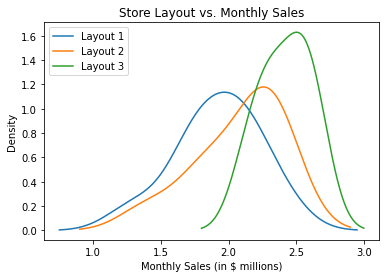

In [7]:
# visualize distribution of different groups
fig, ax = plt.subplots(1,1)
for s in df.columns:
    df[s].plot(kind='density', legend=True)
plt.xlabel('Monthly Sales (in $ millions)')
plt.title('Store Layout vs. Monthly Sales')
fig.show()


Caption to describe what we see above.

## Between-Group Estimate of σ<sup>2</sup>: MSTR

Weighted sum of squared differences between the sample means and the overall mean of the dataset.



In [8]:
# calculate grand mean
sum_observations = df['Layout 1'].sum() + df['Layout 2'].sum() + df['Layout 3'].sum()
sum_observations

64.2

In [9]:
# denominator is number of observations between the 3 columns
grand_mean = sum_observations/(len(df)*len(df.columns))
grand_mean

2.14

In [10]:
# sum of squares
x1 = df['Layout 1'].mean()
x2 = df['Layout 2'].mean()
x3 = df['Layout 3'].mean()
print(x1,x2,x3)

1.92 2.0800000000000005 2.42


In [11]:
def squared_difference(group_mean, grand_mean, n_obs):
  group_difference = n_obs*(group_mean - grand_mean)**2
  return group_difference

In [12]:
sum_of_squares = squared_difference(x1, grand_mean, n_obs=len(df)) + squared_difference(x2, grand_mean, n_obs=len(df)) \
+ squared_difference(x3, grand_mean, n_obs=len(df))
sum_of_squares

1.3039999999999994

In [13]:
# between group estimate of variance
MSTR = sum_of_squares/(len(df.columns)-1)
MSTR

0.6519999999999997

The MSTR is 0.652, is this large enough to indicate that the population means differ? Let's compare this to the variability we can expect due to chance. 

Compare variance between groups to the variance within a group.

## Within-Group Estimate of σ<sup>2</sup>: MSE

degrees of freedom: n<sub>T</sub> - c

In [14]:
# calculate sample variances
s1 = df['Layout 1'].var()
s2 = df['Layout 2'].var()
s3 = df['Layout 3'].var()
print(s1,s2,s3)

0.09733333333333333 0.1062222222222222 0.03733333333333335


In [16]:
def calc_SSE(sample_variance, n_obs):
  """
  Inputs of function, output, what does this function do?
  """
  return (n_obs-1)*sample_variance

In [17]:
SSE = calc_SSE(s1, n_obs=len(df)) + calc_SSE(s2, n_obs=len(df)) + calc_SSE(s3, n_obs=len(df))
SSE

2.168

In [18]:
# Divide SSE by degrees of freedom
ddof = (len(df)*len(df.columns)) - len(df.columns)
MSE = SSE/ddof
MSE

0.0802962962962963

If the ratio between group variance vs. within group variance is signficiantly greater than 1, then we have evidence to reject the null hypothesis.

In [19]:
# degrees of freedom from MSE
ddof

27

In [20]:
# degrees of freedom for MSTR (c - 1)
len(df.columns)-1

2

In [21]:
F = MSTR/MSE
F

8.11992619926199

In [24]:
# calculate the test statistic
p_value = 1 - stats.f.cdf(F, 2, ddof)
p_value

0.0017337005157636032

In [28]:
alpha

0.05

In [34]:
p_value < alpha

True

In [35]:
# State the conclusion and interpret the results
if p_value > alpha:
  print("Fail to reject the null hypothesis")
if p_value < alpha:
  print("Evidence to support the alternative hypothesis that the means are different at the significance level found")


Evidence to support the alternative hypothesis that the means are different at the significance level found


This is lower than our alpha of 0.05 so we have evidence to reject the null hypothesis that the variance of monthly sales is different between the groups.

**It's important to note that we cannot conclude which means are equal or different**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

Can also use python's package

In [36]:
stats.f_oneway(df['Layout 1'], df['Layout 2'], df['Layout 3'])

F_onewayResult(statistic=8.119926199261991, pvalue=0.0017337005157635715)

Back to lecture

## Fisher’s Least Significant Difference (LSD) Method

Calculate 95% confidence intervals to identify which store layout resulted in statistically significant difference in sales.

H<sub>0</sub>
 :  μ<sub>1</sub> - μ<sub>2</sub> = 0

H<sub>A</sub> : Not all population means are equal

H<sub>0</sub>
 :  μ<sub>1</sub> - μ<sub>3</sub> = 0

H<sub>A</sub> : Not all population means are equal

H<sub>0</sub>
 :  μ<sub>2</sub> - μ<sub>3</sub> = 0

H<sub>A</sub> : Not all population means are equal

In [37]:
(1-.95) / 2

0.025000000000000022

In [38]:
critical_val = stats.t.ppf(1-0.025, ddof)
critical_val

2.0518305164802833

In [39]:
def fisher_confidence_interval(x1_, x2_, MSE_, n1_, n2_):
  upper_bound = (x1_ - x2_) + critical_val * math.sqrt(MSE_ * ((1/n1_) + (1/n2_)))
  lower_bound = (x1_ - x2_) - critical_val * math.sqrt(MSE_ * ((1/n1_) + (1/n2_)))
  return lower_bound, upper_bound

In [40]:
fisher_confidence_interval(x1, x2, MSE, len(df['Layout 1']), len(df['Layout 2']))

(-0.42001849449042356, 0.10001849449042238)

In [41]:
fisher_confidence_interval(x1, x3, MSE, len(df['Layout 1']), len(df['Layout 3']))

(-0.7600184944904229, -0.23998150550957703)

In [42]:
fisher_confidence_interval(x2, x3, MSE, len(df['Layout 2']), len(df['Layout 3']))

(-0.6000184944904223, -0.07998150550957644)

If the interval contains the value zero, we fail to reject the null hypothesis. 

For the first interval, we cannot conclude that the mean monthly sales differ between Layout 1 and Layout 2.

For the intervals between 1 and 3 and 2 and 3 the values are both below zero, where we can conclude that the means are statistically signficicant in their differences.

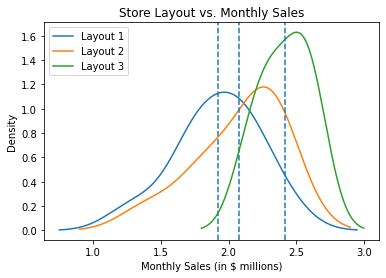

In [43]:
# visualize distribution of different groups
fig, ax = plt.subplots(1,1)
for s in df.columns:
    df[s].plot(kind='density', legend=True)
    plt.axvline(x=df[s].mean(),  linestyle='--')
plt.xlabel('Monthly Sales (in $ millions)')
plt.title('Store Layout vs. Monthly Sales')
fig.show()

Visualize how the means between Layout 1 and Layout 2 are very close to eachother, compared to layout 3 which has a more unique distribution and statistically significant difference in the mean.

## Tukey’s Honestly Significant Difference (HSD) Method

https://www.statsmodels.org/dev/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html

In [44]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'])
df_melt.head()

,index,variable,value
0,0,Layout 1,1.3
1,1,Layout 1,1.8
2,2,Layout 1,2.4
3,3,Layout 1,2.1
4,4,Layout 1,1.7


In [45]:
# replace column names
df_melt.columns = ['index', 'layout', 'value']

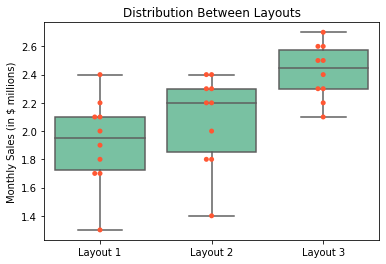

In [48]:
ax = sns.boxplot(x='layout', y='value', data=df_melt, color='#6DCDA3')
ax = sns.swarmplot(x="layout", y="value", data=df_melt, color='#FF5733')
plt.title('Distribution Between Layouts')
plt.xlabel("")
plt.ylabel("Monthly Sales (in $ millions)")
plt.show()

Visualize variance between groups and within. Layout 3 seems to consistently deliver higher monthly sales.

In [49]:
df_stack = df.stack().reset_index()#[0]
df_stack.head()

,level_0,level_1,0
0,0,Layout 1,1.3
1,0,Layout 2,2.0
2,0,Layout 3,2.6
3,1,Layout 1,1.8
4,1,Layout 2,2.2


In [56]:
p1_tukey_test = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['layout'], alpha=0.05)

In [57]:
p1_tukey_test._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
Layout 1,Layout 2,0.16,0.4296,-0.1541,0.4741,False
Layout 1,Layout 3,0.5,0.0014,0.1859,0.8141,True
Layout 2,Layout 3,0.34,0.0319,0.0259,0.6541,True


Neat! It tells us the mean difference in addition to the p value and lower and upper boundaries, using the alpha of .05 we can follow if the interval crosses 0.

In [58]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(layout)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(layout),1.304,2.0,8.119926,0.001734
Residual,2.168,27.0,NaN,NaN


In [61]:
#!pip install bioinfokit

In [62]:
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='layout', anova_model='value ~ C(layout)')
res.tukey_summary

/usr/local/lib/python3.7/dist-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Layout 1,Layout 2,0.16,-0.154146,0.474146,1.785551,0.429597
1,Layout 1,Layout 3,0.50,0.185854,0.814146,5.579846,0.001435
2,Layout 2,Layout 3,0.34,0.025854,0.654146,3.794296,0.031916


### Test ANOVA assumptions

- Check using test statistics and visual approachs such as residual plots and histograms

- Test the normality assumption with QQ-plot from standardized residuals

A QQ-plot is a probability plot to show percent of points for a given value. For example, 25% of values fall at the first quantile.

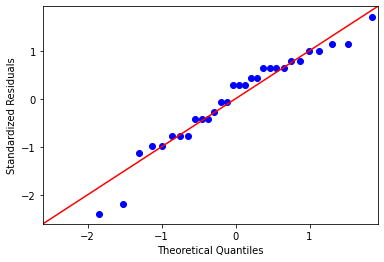

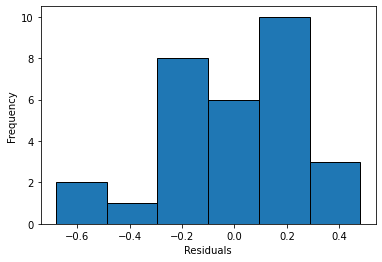

In [63]:
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

Analyzing the residuals of the ANOVA, we see they lie around the 45 degree line, suggesting that the residuals are normally distributed.

The histogram confirms this where the residuals are normally distributed.

____

## Two-Way ANOVA Test: No Interaction

"A two-way ANOVA test is used to simultaneously examine the effect of two factors on the population mean. This test can be conducted with or without the interaction of the factors."

At the 5% significance level, conduct a one-way ANOVA test to determine if the mean income is different between fields of employment.

In [64]:
df = pd.read_excel("https://lectures.mhhe.com/connect/jaggia4e_1260719294/student/data_files/jaggia_BS_4e_ch13_Data_Files.xlsx", 
                   sheet_name="One_Factor")

In [65]:
df

,Educational Services,Financial Services,Medical Services
0,35,58,110
1,18,90,62
2,75,25,26
3,46,45,43


In [66]:
df.columns

Index(['Educational Services', 'Financial Services', 'Medical Services'], dtype='object')

In [67]:
stats.f_oneway(df[df.columns[0]], df[df.columns[1]], df[df.columns[2]])

F_onewayResult(statistic=0.32998007022871784, pvalue=0.7272810766077812)

In [68]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'])
df_melt.head()

,index,variable,value
0,0,Educational Services,35
1,1,Educational Services,18
2,2,Educational Services,75
3,3,Educational Services,46
4,0,Financial Services,58


In [69]:
# replace column names
df_melt.columns = ['index', 'industry', 'value']

In [70]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(industry)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(industry),579.50,2.0,0.32998,0.727281
Residual,7902.75,9.0,NaN,NaN


In [71]:
# Now for two factor
df1 = pd.read_excel("https://lectures.mhhe.com/connect/jaggia4e_1260719294/student/data_files/jaggia_BS_4e_ch13_Data_Files.xlsx", 
                   sheet_name="Two_Factor")

In [72]:
df1

,Unnamed: 0,Educational Services,Financial Services,Medical Services
0,No High School,18,25,26
1,High School,35,45,43
2,Bachelor’s,46,58,62
3,Master’s,75,90,110


In [73]:
df1_melt = pd.melt(df1, id_vars=['Unnamed: 0'], value_vars=['Educational Services', 'Financial Services', 'Medical Services'])

In [74]:
# replace column names
df1_melt.columns = ['education', 'industry', 'value']
df1_melt

,education,industry,value
0,No High School,Educational Services,18
1,High School,Educational Services,35
2,Bachelor’s,Educational Services,46
3,Master’s,Educational Services,75
4,No High School,Financial Services,25
5,High School,Financial Services,45
6,Bachelor’s,Financial Services,58
7,Master’s,Financial Services,90
8,No High School,Medical Services,26
9,High School,Medical Services,43


Visualize difference between means for each factor

Text(0.5, 1.0, 'Distribution for Factor: Education')

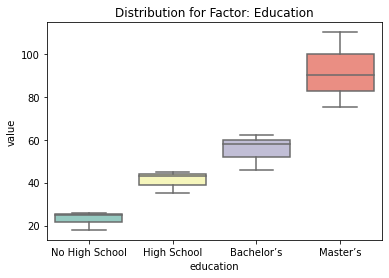

In [75]:
sns.boxplot(x="education", y="value", data=df1_melt, palette="Set3") 
plt.title('Distribution for Factor: Education')

Text(0.5, 1.0, 'Distribution for Factor: Industry')

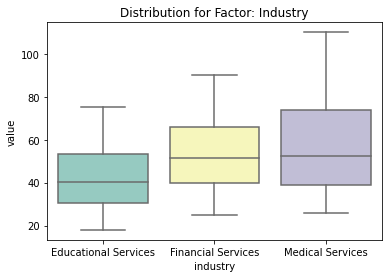

In [76]:
sns.boxplot(x="industry", y="value", data=df1_melt, palette="Set3") 
plt.title('Distribution for Factor: Industry')

Means for industry factor

In [77]:
x_edu = df['Educational Services'].mean()
x_fin = df['Financial Services'].mean()
x_med = df['Medical Services'].mean()

print(x_edu, x_fin, x_med)

43.5 54.5 60.25


Means for education level

In [78]:
x_nhs = df1_melt[df1_melt['education'] == 'No High School']['value'].mean()
x_hs = df1_melt[df1_melt['education'] == 'High School']['value'].mean()
x_ba = df1_melt[df1_melt['education'] == "Bachelor’s"]['value'].mean()
x_m = df1_melt[df1_melt['education'] == "Master’s"]['value'].mean()

print(x_nhs, x_hs, x_ba, x_m)

23.0 41.0 55.333333333333336 91.66666666666667


In [79]:
# grand mean
x_grand = df1_melt['value'].mean()
x_grand

52.75

In [80]:
n_groups = len(df1_melt['education'].unique())
n_groups

4

In [81]:
def square_dif(x_group, x_grand):
  """
  Calculate the square difference between the value and the grand mean
  """
  return (x_group - x_grand)**2

In [82]:
SSA = n_groups*(square_dif(x_edu, x_grand) + square_dif(x_fin, x_grand)+ square_dif(x_med, x_grand))
SSA

579.5

In [83]:
# divide by degrees of freedom
c = len(df1_melt['industry'].unique())
c

3

In [84]:
MSA = SSA/(c-1)
MSA

289.75

In [85]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(industry)', data=df1_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(industry),579.50,2.0,0.32998,0.727281
Residual,7902.75,9.0,NaN,NaN


In [86]:
# for factor B (education)

n_groups = len(df1_melt['industry'].unique())

In [87]:
SSB = n_groups*(square_dif(x_nhs, x_grand) + square_dif(x_hs, x_grand) + square_dif(x_ba, x_grand) + square_dif(x_m, x_grand))
SSB

7632.916666666667

In [88]:
# divide by degrees of freedom
r = len(df1_melt['education'].unique())
r

4

In [89]:
MSB = SSB/(r-1)
MSB

2544.3055555555557

In [90]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(education)', data=df1_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(education),7632.916667,3.0,23.965201,0.000237
Residual,849.333333,8.0,NaN,NaN


In [91]:
def tss(a):
    """
    https://stackoverflow.com/questions/69420861/total-sum-of-squares-tss-in-python
    Calculates the total sum of squares for the value column by 
    looping through each row and dividing by the grand mean
    """
    from statistics import mean
    m = mean(a)
    n = 0
    for i in a:
        n += ((i-m)**2)
    return (n)

In [92]:
SST = tss(df1_melt['value'])
SST

8482.25

SSE = SST - (SSA+SSB)

In [93]:
# Compute SSE as 
SSE = SST - (res.anova_summary.sum_sq[0] + res.anova_summary.sum_sq[1])
SSE

8478.778

How to interpret? When we used one factor to explain the annual incomes, say the industry of employment we see the SSE was 7902.75, by ignoring the second factor (education level) we didn't see a significant difference by field of employment. 

When we include the second factor, the Sum of Squares error is 269.83. 

In [94]:
# divide SSE by degrees of freedom to obtain the mean squared error MSE
# ddof = nT - c - r + 1

MSE = SSE/ (len(df1_melt) - len(df1_melt['industry'].unique()) - len(df1_melt['education'].unique()) + 1)
MSE

1413.1296666666667

Bring it all together and interpret each factor's sum of squares and the final residual. 

State the hypothesis: 

H<sub>0</sub>
 :  μ<sub>education</sub> = μ<sub>financial</sub> = μ<sub>medical</sub>

H<sub>A</sub> : Not all population means are equal

In [95]:
model = ols('value ~ C(education) +  C(industry)', data=df1_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(education),7632.916667,3.0,56.575046,0.000086
C(industry),579.500000,2.0,6.442866,0.032067
Residual,269.833333,6.0,NaN,NaN


In [96]:
res = stat()
res.anova_stat(df=df1_melt, res_var='value', anova_model='value~C(education)+C(industry)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(education),3.0,7632.916667,2544.305556,56.575046,0.000086
C(industry),2.0,579.500000,289.750000,6.442866,0.032067
Residual,6.0,269.833333,44.972222,NaN,NaN


For industry, the F score is 6.44 and p value is less than .05, therefore we reject the null hypothesis and when we see this interaction the annual salaries do differ by field of employment at the 5% significance level. This was not the case when we didn't take into account the interaction.

For education, the F score is 56.57 and p value is less than .05, therefore we reject the null hypothesis and when we see this interaction the annual salaries do differ by level of education at the 5% significance level. We see this factor had a significant effect on the distribution of annual salary. 

In [97]:
res = stat()

In [98]:
res.tukey_hsd(df=df1_melt, res_var='value', xfac_var='education', anova_model='value~C(education)+C(industry)')

/usr/local/lib/python3.7/dist-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


In [99]:
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,No High School,High School,18.000000,-0.957295,36.957295,4.649015,0.061262
1,No High School,Bachelor’s,32.333333,13.376039,51.290628,8.351009,0.004249
2,No High School,Master’s,68.666667,49.709372,87.623961,17.735132,0.001000
3,High School,Bachelor’s,14.333333,-4.623961,33.290628,3.701994,0.136322
4,High School,Master’s,50.666667,31.709372,69.623961,13.086117,0.001000
5,Bachelor’s,Master’s,36.333333,17.376039,55.290628,9.384123,0.002314


In [100]:
res.tukey_hsd(df=df1_melt, res_var='value', xfac_var='industry', anova_model='value~C(education)+C(industry)')
res.tukey_summary

/usr/local/lib/python3.7/dist-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Educational Services,Financial Services,11.00,-3.532641,25.532641,3.280579,0.128051
1,Educational Services,Medical Services,16.75,2.217359,31.282641,4.995427,0.028449
2,Financial Services,Medical Services,5.75,-8.782641,20.282641,1.714848,0.489732


In [101]:
res.tukey_hsd(df=df1_melt, res_var='value', xfac_var=['industry', 'education'], anova_model='value~C(education)+C(industry)')
res.tukey_summary

/usr/local/lib/python3.7/dist-packages/bioinfokit/analys.py:369: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(Educational Services, No High School)","(Educational Services, High School)",17.0,-28.525246,62.525246,2.534993,0.770021
1,"(Educational Services, No High School)","(Educational Services, Bachelor’s)",28.0,-17.525246,73.525246,4.175282,0.303462
2,"(Educational Services, No High School)","(Educational Services, Master’s)",57.0,11.474754,102.525246,8.499682,0.017349
3,"(Educational Services, No High School)","(Financial Services, No High School)",7.0,-38.525246,52.525246,1.043821,0.900000
4,"(Educational Services, No High School)","(Financial Services, High School)",27.0,-18.525246,72.525246,4.026165,0.335945
...,...,...,...,...,...,...,...
61,"(Medical Services, No High School)","(Medical Services, Bachelor’s)",36.0,-9.525246,81.525246,5.368220,0.131423
62,"(Medical Services, No High School)","(Medical Services, Master’s)",84.0,38.474754,129.525246,12.525847,0.002278
63,"(Medical Services, High School)","(Medical Services, Bachelor’s)",19.0,-26.525246,64.525246,2.833227,0.677880
64,"(Medical Services, High School)","(Medical Services, Master’s)",67.0,21.474754,112.525246,9.990854,0.007635


In [ ]:
# using pairwise_tukey

In [102]:
p1_tukey_test = pairwise_tukeyhsd(endog=df1_melt['value'], groups=df1_melt['education'], alpha=0.05)

In [103]:
p1_tukey_test._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
Bachelor’s,High School,-14.3333,0.3822,-41.2773,12.6107,False
Bachelor’s,Master’s,36.3333,0.0109,9.3893,63.2773,True
Bachelor’s,No High School,-32.3333,0.0206,-59.2773,-5.3893,True
High School,Master’s,50.6667,0.0014,23.7227,77.6107,True
High School,No High School,-18.0,0.22,-44.944,8.944,False
Master’s,No High School,-68.6667,0.001,-95.6107,-41.7227,True


In [104]:
p2_tukey_test =  pairwise_tukeyhsd(endog=df1_melt['value'], groups=df1_melt['industry'], alpha=0.05)

In [105]:
p2_tukey_test._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
Educational Services,Financial Services,11.0,0.8535,-47.4528,69.4528,False
Educational Services,Medical Services,16.75,0.7029,-41.7028,75.2028,False
Financial Services,Medical Services,5.75,0.9,-52.7028,64.2028,False


## Two-Way ANOVA: With Interaction

We use a two-way ANOVA test with interaction to capture the possible relationship between factors A and B. Where we are looking to understand if there is an influence of A to change other levels of factor B and vice versa. From our last example, we would investigate if there is a relationship between level of education and the field of employment. The main difference between ANOVA with interaction and without interaction is the addition of the interaction between two factors.

In [106]:
df = pd.read_excel("https://lectures.mhhe.com/connect/jaggia4e_1260719294/student/data_files/jaggia_BS_4e_ch13_Data_Files.xlsx",
                   sheet_name='Interaction')

In [107]:
df.shape

(12, 4)

In [108]:
# fill na with the education type
df['Unnamed: 0'].fillna(method='ffill', inplace=True)

In [109]:
df

,Unnamed: 0,Educational,Financial,Medical
0,No High School,20,27,26
1,No High School,25,25,24
2,No High School,22,25,25
3,High School,30,44,42
4,High School,35,46,43
5,High School,34,48,45
6,Bachelor's,46,50,62
7,Bachelor's,47,58,56
8,Bachelor's,50,56,60
9,Master's,79,90,90


In [110]:
df2_melt = pd.melt(df, id_vars=['Unnamed: 0'], value_vars=['Educational', 'Financial', 'Medical'])

In [111]:
# replace column names
df2_melt.columns = ['education', 'industry', 'value']
df2_melt.head()

,education,industry,value
0,No High School,Educational,20
1,No High School,Educational,25
2,No High School,Educational,22
3,High School,Educational,30
4,High School,Educational,35


Text(0.5, 1.0, 'Distribution for Factor: Industry')

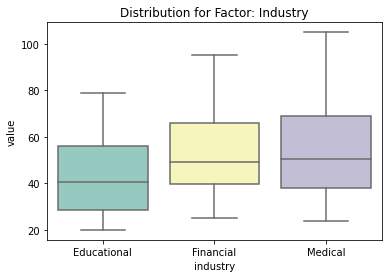

In [112]:
sns.boxplot(x="industry", y="value", data=df2_melt, palette="Set3") 
plt.title('Distribution for Factor: Industry')

Text(0.5, 1.0, 'Distribution for Factor: Education')

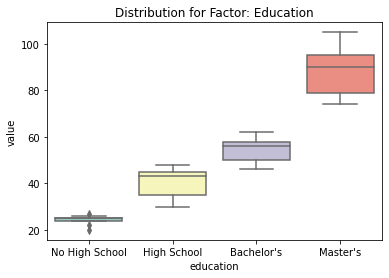

In [113]:
sns.boxplot(x="education", y="value", data=df2_melt, palette="Set3") 
plt.title('Distribution for Factor: Education')

In [114]:
# visualize the means for each interaction
df_mean = df.groupby(['Unnamed: 0'])[['Educational', 'Financial', 'Medical']].mean()#.reset_index()
df_mean

,Educational,Financial,Medical
Unnamed: 0,,,
Bachelor's,47.666667,54.666667,59.333333
High School,33.000000,46.000000,43.333333
Master's,77.000000,92.333333,98.333333
No High School,22.333333,25.666667,25.000000


In [115]:
# Factor A means
x_edu = df_mean.Educational.mean()
x_fin = df_mean.Financial.mean()
x_med = df_mean.Medical.mean()
print(x_edu, x_fin, x_med)

45.0 54.666666666666664 56.5


In [116]:
x_nhs = df_mean.loc["No High School"].mean()
x_hs = df_mean.loc["High School"].mean()
x_ba = df_mean.loc["Bachelor's"].mean()
x_m = df_mean.loc["Master's"].mean()
print(x_nhs, x_hs, x_ba, x_m)

24.333333333333332 40.77777777777778 53.888888888888886 89.22222222222221


In [117]:
# grand mean - using the melted table
grand_mean = df2_melt.value.mean()
grand_mean

52.05555555555556

In [118]:
# calculate the Total Sum of Squares (SST)
# let's use our previous function
SST_list = []
for i in range(len(df2_melt.value)):
  print("Calculate difference between:", df2_melt.value[i])
  dif_val = square_dif(df2_melt.value[i], grand_mean)
  SST_list.append(dif_val)

Calculate difference between: 20
Calculate difference between: 25
Calculate difference between: 22
Calculate difference between: 30
Calculate difference between: 35
Calculate difference between: 34
Calculate difference between: 46
Calculate difference between: 47
Calculate difference between: 50
Calculate difference between: 79
Calculate difference between: 78
Calculate difference between: 74
Calculate difference between: 27
Calculate difference between: 25
Calculate difference between: 25
Calculate difference between: 44
Calculate difference between: 46
Calculate difference between: 48
Calculate difference between: 50
Calculate difference between: 58
Calculate difference between: 56
Calculate difference between: 90
Calculate difference between: 92
Calculate difference between: 95
Calculate difference between: 26
Calculate difference between: 24
Calculate difference between: 25
Calculate difference between: 42
Calculate difference between: 43
Calculate difference between: 45
Calculate 

In [119]:
# take the sum of each difference
SST = sum(SST_list)
SST

22007.888888888887

In [120]:
# Sum of Squares for factor A

r_groups = len(df2_melt['industry'].unique())
c_groups = len(df2_melt['education'].unique())
r_groups, c_groups

(3, 4)

In [121]:
SSA = r_groups*c_groups * (square_dif(x_edu, grand_mean) + square_dif(x_fin, grand_mean) + square_dif(x_med, grand_mean) )
SSA

916.2222222222222

In [122]:
MSA = SSA/(r_groups - 1)
MSA

458.1111111111111

In [123]:
# Sum of Squares for factor B
# 3 observations for each group
df['Unnamed: 0'].value_counts()

No High School    3
High School       3
Bachelor's        3
Master's          3
Name: Unnamed: 0, dtype: int64

In [124]:
n_obs_per_group = 3

In [125]:
r_groups = len(df2_melt['industry'].unique())
r_groups

3

In [126]:
print(x_nhs, x_hs, x_ba, x_m)

24.333333333333332 40.77777777777778 53.888888888888886 89.22222222222221


In [127]:
SSB = r_groups*n_obs_per_group * (square_dif(x_nhs, grand_mean) + square_dif(x_hs, grand_mean)
  + square_dif(x_ba, grand_mean) + square_dif(x_m, grand_mean))
SSB

20523.888888888883

In [128]:
MSB = SSB/(c_groups - 1)
MSB

6841.296296296295

In [129]:
# Calculate the Sum of Squares for interaction of Factor A and B

# df_mean.rename(columns= {'Unnamed: 0':'education'}, inplace=True)

df_mean

,Educational,Financial,Medical
Unnamed: 0,,,
Bachelor's,47.666667,54.666667,59.333333
High School,33.000000,46.000000,43.333333
Master's,77.000000,92.333333,98.333333
No High School,22.333333,25.666667,25.000000


In [130]:
def calc_interaction(factor_a_name, factor_b_name, grand_mean):
  # take mean value between columns
  # subtract mean of each factor
  # add the grand mean
  print("Calculate:", factor_a_name,"x", factor_b_name)
  interaction_ = df_mean.loc[factor_b_name][factor_a_name] \
   - df_mean[factor_a_name].mean() - df_mean.loc[factor_b_name].mean() + grand_mean
  # return squared interaction
  return interaction_ ** 2 

In [131]:
df_mean.loc['No High School']['Educational']#.values[0]

22.333333333333332

In [132]:
df_mean['Educational'].mean()

45.0

In [ ]:
df_mean.loc["No High School"].mean()

In [133]:
calc_interaction(factor_a_name='Educational', factor_b_name= 'No High School', grand_mean=grand_mean)

Calculate: Educational x No High School


25.558641975308657

In [134]:
# calculate for all combinations
len(df_mean.index), len(df_mean.columns)

(4, 3)

In [135]:
# calculate all combinations
import itertools
all_combos = list(itertools.product(df_mean.columns, df_mean.index))
all_combos

[('Educational', "Bachelor's"),
 ('Educational', 'High School'),
 ('Educational', "Master's"),
 ('Educational', 'No High School'),
 ('Financial', "Bachelor's"),
 ('Financial', 'High School'),
 ('Financial', "Master's"),
 ('Financial', 'No High School'),
 ('Medical', "Bachelor's"),
 ('Medical', 'High School'),
 ('Medical', "Master's"),
 ('Medical', 'No High School')]

In [136]:
total_sum = []
for factor_a, factor_b in all_combos:
  total_sum.append(calc_interaction(factor_a_name=factor_a, factor_b_name=factor_b, grand_mean=grand_mean))

Calculate: Educational x Bachelor's
Calculate: Educational x High School
Calculate: Educational x Master's
Calculate: Educational x No High School
Calculate: Financial x Bachelor's
Calculate: Financial x High School
Calculate: Financial x Master's
Calculate: Financial x No High School
Calculate: Medical x Bachelor's
Calculate: Medical x High School
Calculate: Medical x Master's
Calculate: Medical x No High School


In [137]:
# multiply sum by number of observations per cell, for each factor group, there are 3 observations
w = len(df_mean.columns)
SSAB = w*(sum(total_sum))
SSAB

318.4444444444442

In [138]:
# obtain mean square by dividng SSAB by degrees of freedom (c-1)(r-1)

MSAB = SSAB/((len(df_mean.columns)-1)*(len(df_mean.index)-1))
MSAB

53.074074074074026

Solve for the Error Sum of Squares, SSE

SSE = SST - (SSA + SSB + SSAB)

In [139]:
SSE = SST - (SSA + SSB + SSAB)
SSE

249.33333333333576

Divide SSE by degrees of freedom rc(w - 1) for the Mean Square Error

In [140]:
MSE = SSE/((len(df_mean.columns))*(len(df_mean.index))*(w-1))
MSE

10.38888888888899

In [141]:
# using statsmodels

df2_melt.head()

,education,industry,value
0,No High School,Educational,20
1,No High School,Educational,25
2,No High School,Educational,22
3,High School,Educational,30
4,High School,Educational,35


In [142]:
res = stat()
res.anova_stat(df=df2_melt, res_var='value', anova_model='value ~ C(industry) +C(education)  + C(industry):C(education)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(industry),2.0,916.222222,458.111111,44.096257,9.182657e-09
C(education),3.0,20523.888889,6841.296296,658.520499,3.582203e-23
C(industry):C(education),6.0,318.444444,53.074074,5.108734,1.659488e-03
Residual,24.0,249.333333,10.388889,NaN,NaN


How to interpret?

We can analyze the sum of squares difference for the groups which aligns with the box-plots we showed. The sum squared difference between education groups is much wider than between the industry alone. The interaction between groups showed a tighter variance which can help inform our interpretation of how these factors might be used to predict the likely income. 

The F statisic is used to measure the variation between sample means/variation within the samples. So the variation betwen education levels vs. income is a lot more varried compared to the interaction between education x industry. 